In [1]:
import pickle
import numpy as np
import pandas as pd
import random
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

### Load synthetic GPS trajectories from file

The dataset is stored in the common pickle format, with two separate files for attribute information and trip trajectory. 


In [2]:
# Load the attributes
attr_path = './attrs_Chengdu.pkl'
with open(attr_path, 'rb') as f:
    attrs = pickle.load(f)
   
# Load the trajectories
trajs_path= './trajs_Chengdu.pkl'
with open(trajs_path, 'rb') as f:
    trajs = pickle.load(f)

print('Number of synthetic trajectories: {:d}'.format(len(attrs)))
print(attrs.shape)
print(len(trajs))

Number of synthetic trajectories: 1000000
(1000000, 4)
1000000


### Data format

For **attribute** information, each example typically includes the following fields:

+ **Trip distance**: Records the distance for each trip (meter), this distance is calculated by map-matching.
+ **Trip time**: The total time of the trip (second), this is the raw trip time.
+ **Departure time**: The departure time of trip, with 5-min duration for each value (288 slices in a day).
+ **Sample points**: Total number of trajectory sampling points for each trip.



In [3]:
print('attributes of the first trip: [trip distance, trip time, departure time, sample points] \n',attrs[0])

trip_distance, trip_time, depart_time, sample_points = attrs[:,0], attrs[:,1], attrs[:,2], attrs[:,3]

attributes of the first trip: [trip distance, trip time, departure time, sample points] 
 [7199.12799413  707.          243.          230.        ]


### Notes for attribute calculation

The **attribute**  given in this dataset is the raw data attributes of GPS trajectory, which are used to guide the model to generate the synthetic GPS data.

In this notebook, we also provide the code to calculate the **trip distance** and **trip time** from the synthetic GPS trajectory data.

For the trip **trajectory**, each sample is represented as a sequence of successively sampled GPS points with recorded longitude and latitude, respectively

In [4]:
print('trajectory of the first trip: \n', trajs[0].shape)
print(trajs[0])

trajectory of the first trip: 
 (229, 2)
[[104.07896554  30.6697435 ]
 [104.07898133  30.6698124 ]
 [104.07900428  30.66978641]
 [104.0790252   30.66977384]
 [104.07904932  30.66977704]
 [104.07906396  30.66978619]
 [104.07906739  30.66980362]
 [104.07909316  30.66983447]
 [104.07914393  30.66988687]
 [104.07919125  30.66995668]
 [104.07927855  30.67004216]
 [104.07937593  30.67012205]
 [104.07947908  30.67020706]
 [104.07959192  30.67028715]
 [104.07972028  30.67033452]
 [104.07986878  30.67033725]
 [104.08001188  30.67030746]
 [104.08014886  30.67027445]
 [104.08028773  30.67023782]
 [104.08042371  30.67020663]
 [104.08056566  30.67018154]
 [104.08071609  30.67016501]
 [104.08086644  30.6701568 ]
 [104.08100683  30.67014531]
 [104.08113145  30.67014495]
 [104.08126074  30.67013143]
 [104.08141462  30.67010484]
 [104.08155534  30.67008806]
 [104.08169736  30.67007331]
 [104.08185189  30.67004815]
 [104.08200657  30.67001698]
 [104.08215608  30.6699978 ]
 [104.08229686  30.66994834]
 [

To calculated the distance, we use the [geopy](https://geopy.readthedocs.io/en/stable/#module-geopy.distance) package to calculate the distance between two points on the earth surface. And then cumulate the distance to get the total trip distance.

In [5]:
import multiprocessing as mp
from geopy.distance import distance
def compute_total_distance(traj):
    distances = [distance(traj[i][::-1], traj[i+1][::-1]).m for i in range(len(traj)-1)]
    return sum(distances)

# This is a high computational task, we use multiprocessing for parallel computing
def compute_total_distance_parallel(trajectories,num_processes=8):
    pool = mp.Pool(processes=num_processes)
    distance = pool.map(compute_total_distance, trajectories)
    return distance

In [6]:
# just sample 100000 trajectories for the demo
sample_index = random.sample(range(len(trajs)),100000)
sample_trajs = [trajs[i] for i in sample_index]
sample_traj_head = np.array([attrs[i] for i in sample_index])

start_time = time.time()
trip_distance = compute_total_distance_parallel(sample_trajs, num_processes=20)
# trip_distance = compute_total_distance(sample_trajs)
print("Total distance calculation took %.3f seconds" % ((time.time() - start_time)))
# get the points number of each trajectory
length_points=np.array([sample_traj_head[:,3][i] for i in range(len(sample_traj_head))])

Total distance calculation took 181.280 seconds


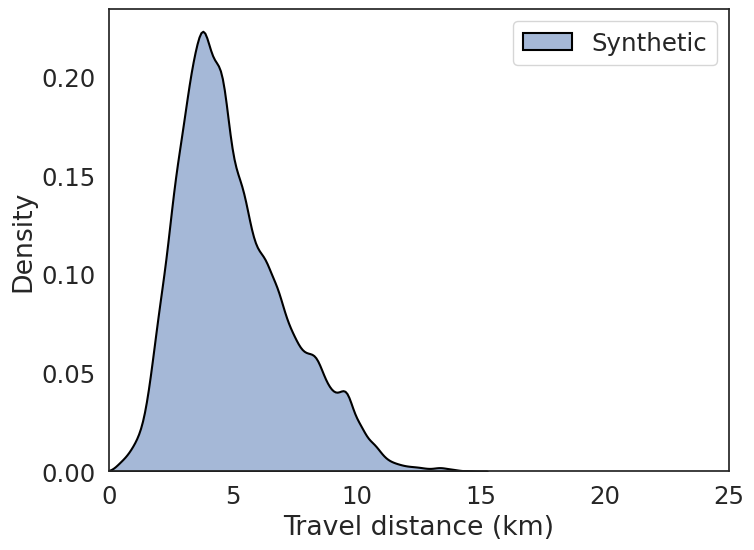

In [7]:
# draw the distance distribution
trip_distance = np.array(trip_distance)
plt.figure(figsize=(8, 6))
sns.color_palette("Paired")
sns.set(font_scale = 1.6)
sns.set_style("white")
sns.kdeplot(trip_distance / 1000, fill=True, edgecolor='black', alpha=0.5, lw= 1.5,label='Synthetic')
# set the x-axis limit
plt.xlim(0, 25)
plt.legend(loc='upper right')
plt.xlabel('Travel distance (km)')
plt.ylabel('Density')
plt.show()

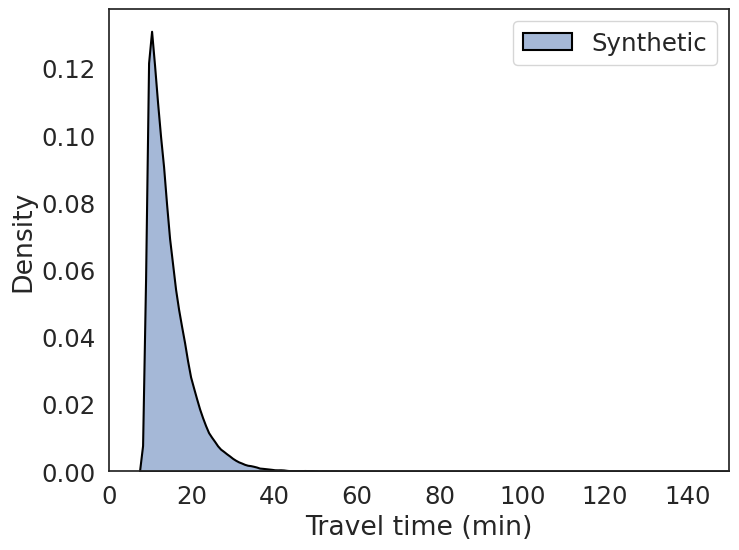

In [8]:
trip_time = length_points*3
plt.figure(figsize=(8, 6))
sns.color_palette("Paired")
sns.set(font_scale = 1.6)
sns.set_style("white")
sns.kdeplot(trip_time / 60, fill=True, edgecolor='black', alpha=0.5, lw= 1.5,label='Synthetic')
plt.xlim(0, 150)
plt.legend(loc='upper right')
plt.xlabel('Travel time (min)')
plt.ylabel('Density')
plt.show()

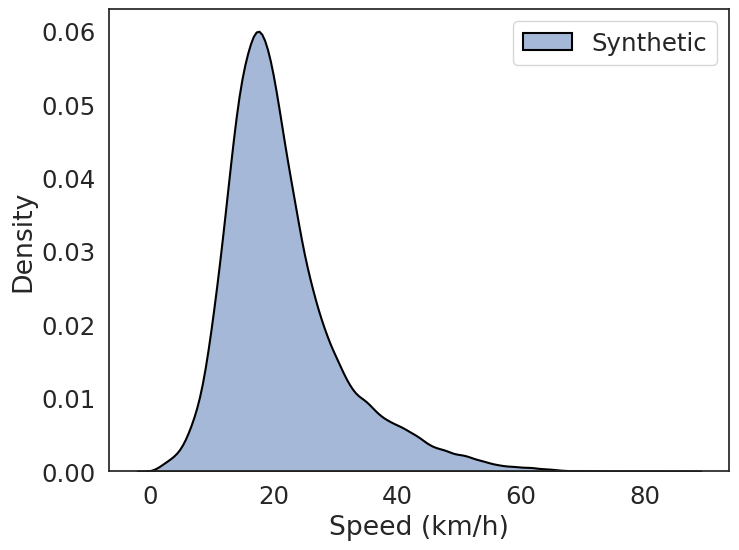

In [9]:
trip_speed = np.array([x / y *3.6 for x, y in zip(trip_distance, trip_time)])
plt.figure(figsize=(8, 6))
sns.color_palette("Paired")
sns.set(font_scale = 1.6)
sns.set_style("white")
sns.kdeplot(trip_speed, fill=True, edgecolor='black', alpha=0.5, lw= 1.5,label='Synthetic')
plt.legend(loc='upper right')
plt.xlabel('Speed (km/h)')
plt.ylabel('Density')
plt.show()

### Data visualization

#### Trajectories

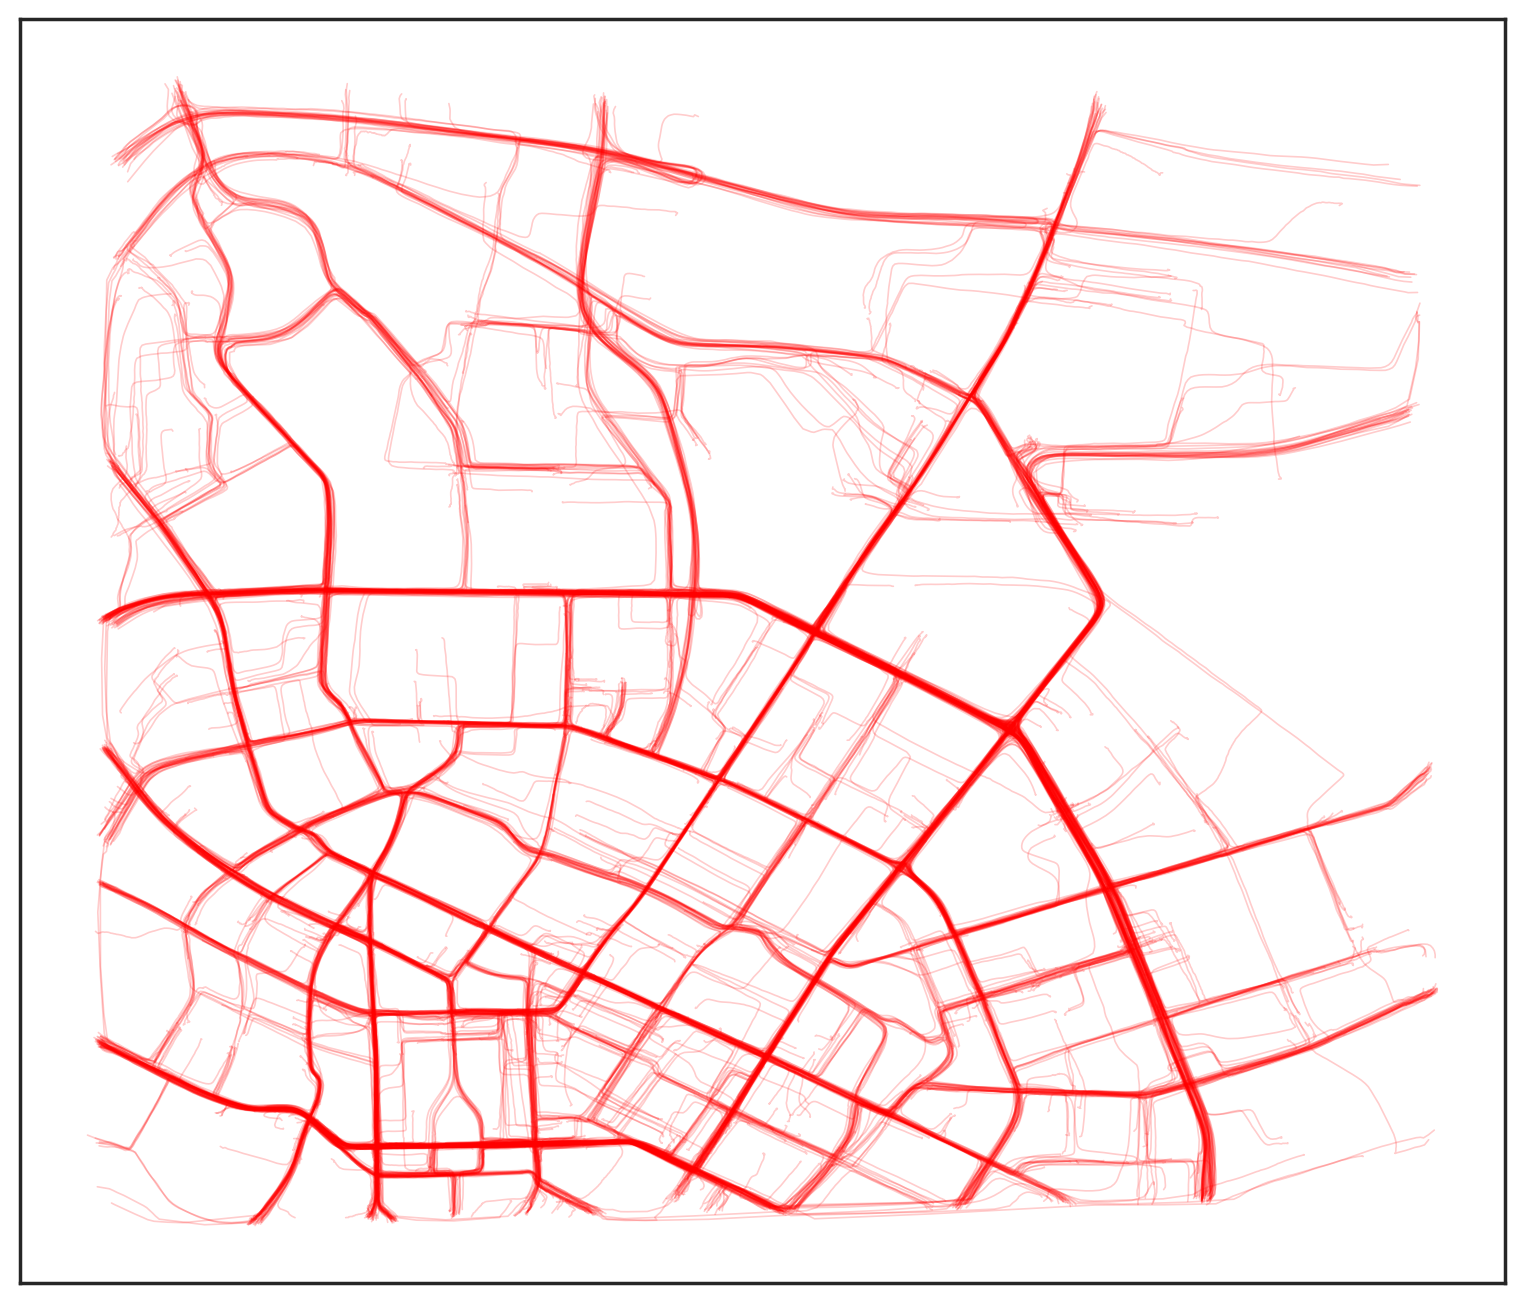

In [10]:
trajs_list = trajs[:1000]
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8, 8))
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.05, right=0.95, hspace=0.02,wspace=0.05)

ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
for j, trip in enumerate(trajs_list):
    ax.plot(trip[:, 0], trip[:, 1], color='red', linewidth=0.6, alpha=0.2)

plt.tight_layout()
plt.show()



#### Generated trajectory distributions with different resolutions

In [11]:
def divide_grids(boundary, grids_num):
    lati_min, long_min = boundary['lati_min'], boundary['long_min']
    lati_max, long_max = boundary['lati_max'], boundary['long_max']
    lati_interval = (lati_max - lati_min) / grids_num
    long_interval = (long_max - long_min) / grids_num
    latgrids = np.arange(lati_min, lati_max, lati_interval)
    longrids = np.arange(long_min, long_max, long_interval)
    return latgrids, longrids


# count the number of points in each grid
def count_points_in_grid(lng, lati, longrids, latgrids):
    lati_index = np.where(lati > latgrids)[0][-1]
    long_index = np.where(lng > longrids)[0][-1]
    return lati_index, long_index

In [12]:
boundary_filepath = 'boundaries_Chengdu.json'
boundary = json.load(open(boundary_filepath))

sample_index = random.sample(range(len(trajs)), 100000)
sample_trajs = [trajs[i] for i in sample_index]

sampled_data = []
for i in range(10000):
    sampled_data.extend(sample_trajs[i].reshape(-1, 2))

origins = []

for grids_num in [16, 32]:

    latgrids, longrids = divide_grids(boundary, grids_num)

    grid_matrix = np.zeros((grids_num, grids_num))
    # count the number of points in each grid
    for i in range(len(sampled_data)):
        lat_index, lng_index = count_points_in_grid(sampled_data[i][0],
                                                    sampled_data[i][1],
                                                    longrids, latgrids)
        grid_matrix[lat_index, lng_index] += 1

    grid_matrix = grid_matrix / grid_matrix.sum()

    origins.append(grid_matrix)


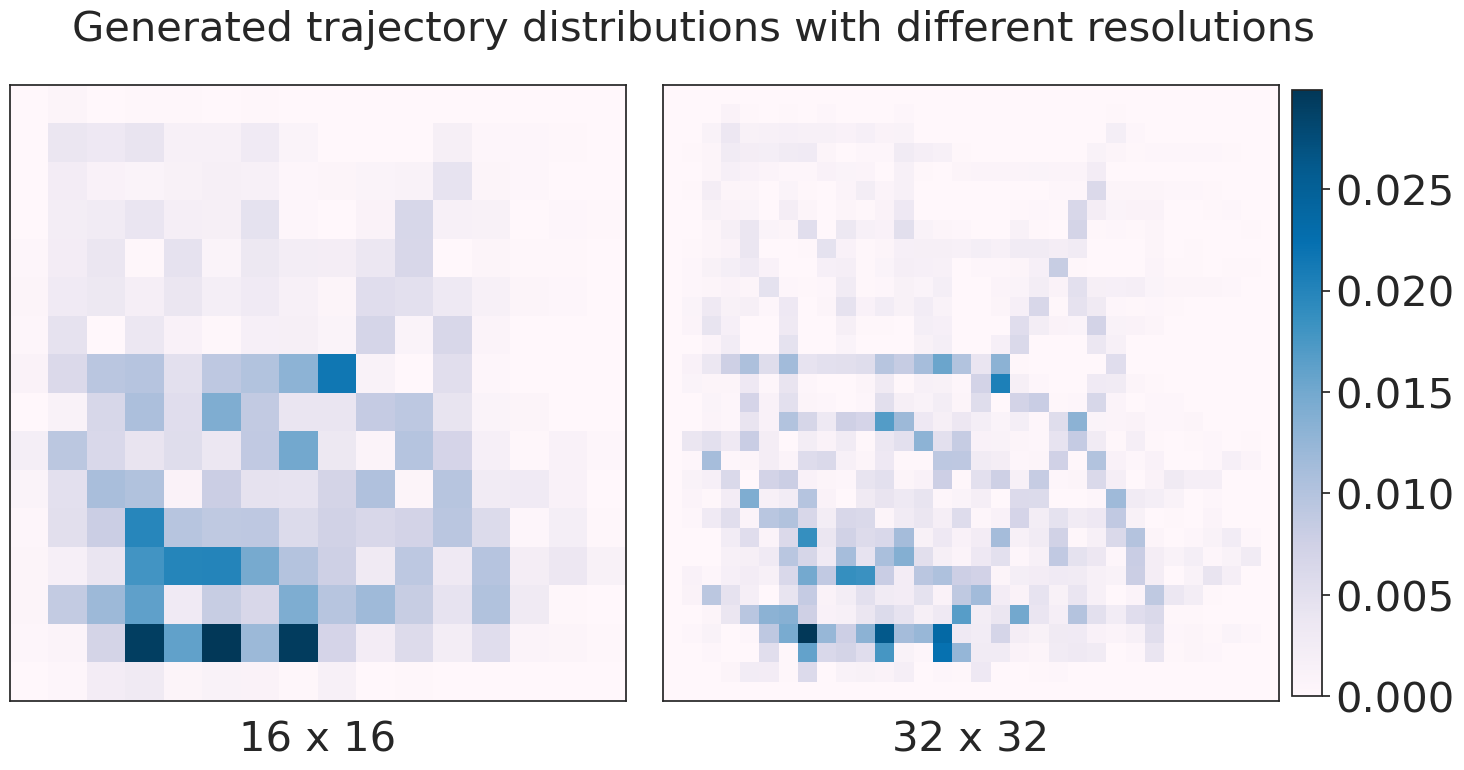

In [13]:
fontsize = 30
fig, axes = plt.subplots(1, 2, figsize=(17, 8))  
fig.subplots_adjust(wspace=0.05, hspace=0)


axes[0].imshow(origins[0][::-1], cmap='PuBu', interpolation='nearest')
axes[1].imshow(origins[1][::-1], cmap='PuBu', interpolation='nearest')

for ax in axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')

axes[0].set_xlabel('16 x 16', fontsize=fontsize)
axes[1].set_xlabel('32 x 32', fontsize=fontsize)


cbar = fig.colorbar(axes[0].get_images()[0], ax=axes, orientation='vertical', fraction=0.023, pad=0.01)
cbar.ax.tick_params(labelsize=fontsize)
fig.text(0.53, 0.95, 'Generated trajectory distributions with different resolutions', ha='center', va='center', fontsize=fontsize)

plt.show()


#### The number of trips throughout the day

In [14]:
trips_throughout, _ = np.histogram(depart_time, bins=np.arange(289))
trips_throughout = trips_throughout / len(attrs)
trips_throughout = np.mean(trips_throughout.reshape((48, -1)), axis=1)

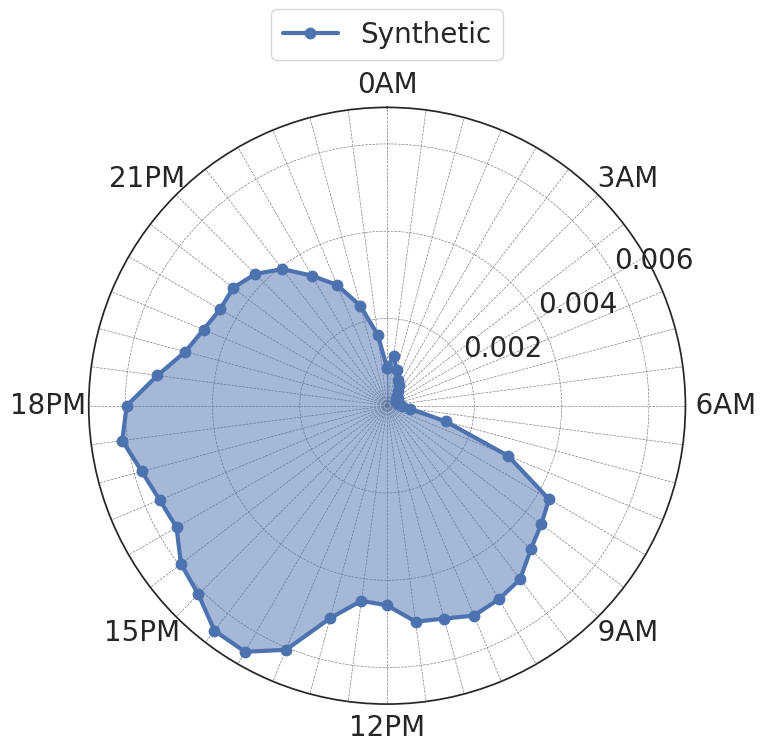

In [15]:
bg_color = plt.rcParams['figure.facecolor']
angles = np.linspace(0, 2*np.pi, 48, endpoint=False)
# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

angles = np.append(angles, angles[0])
trips_throughout = np.append(trips_throughout, trips_throughout[0])

# Plot velocities
ax.fill_between(angles, trips_throughout, color="C0", alpha=0.5)

ax.plot(angles, trips_throughout, '.-', markersize = 15, linewidth=3, label='Synthetic')

labels_text = ['0AM','   3AM','    6AM', '   9AM','12PM', '15PM    ', '18PM    ','21PM   ']
labels = []
for label in labels_text: 
    labels.append(label)
    [labels.append('') for i in range(5)]

ax.set_xticks(np.linspace(0, 2*np.pi, 8 * 6, endpoint=False))
ax.set_xticklabels(labels)  # Clear the default labels
ax.tick_params(labelsize=20)
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
# ax.set_facecolor(bg_color)
# Add grid

# # Set the grid color
ax.grid()
ax.grid(color="gray", linestyle='--', linewidth=0.5)

yticks = [0.002, 0.004, 0.006]
ax.set_yticks(yticks[:])
ax.tick_params('y', labelsize=20)

# Move radial labels to the left
ax.set_rlabel_position(60)  # The angle is in degrees

# Add legend
ax.legend(bbox_to_anchor=(0.5, 1.08), loc='lower center', fontsize=20, ncol=len(ax.lines), borderaxespad=0.)

# Show plot
plt.tight_layout()
plt.show()